
# Overview 
That the definition of "shelter cost" from the Canadian government, has kept wages pegged to a metric called the "Consumer price index".  A broader definition of "shelter cost", that includes concepts such as opportunity cost, paints a picture where home prices are have been increasing in cost relative to purchasing power of wages [1].


According to Statistics Canada, there are a number of different metrics for measuring "shelter cost" in the CPI [1].  These are refered to as : 

* payment
* net acquisition
* rental equivalence
* user cost

Statistics Canada beleives that the most appropriate approach for measuring "shelter cost" in the CPI is the *user cost* approach.  Statistics Canada states [1]:

    "...an owned accomodation index like the one adopted by the Canadian CPI, based on the user cost approach does not seek to measure changes in dwelling prices. Its purpose is to determine changes in the cost of using a stock of dwellings...Those wishing to use the CPI as an indicator of inflation in the housing market must be aware of the inherent limitations of such an approach, and should not expect it to produce an index that automatically tracks movements in dwelling prices."


# Reference
1. Statistics Canada Government of Canada, “Shelter in the Canadian CPI: An Overview,” September 22, 2017, https://www150.statcan.gc.ca/n1/pub/62f0014m/62f0014m2017001-eng.htm.

In [51]:
import os
from stats_can import StatsCan
from stats_can import *
import math
import datetime

In [52]:
import json
import requests
import pandas as pd
import numpy as np
import csv
import seaborn as sns

In [53]:
import matplotlib.pyplot as plt
from matplotlib import interactive
%matplotlib inline

In [54]:
import functools
from toolz import *

Canada's National Balance Sheet since the 1970's shows a systematic decline in the share of "non-residential" structures, machinery and equipment, and consumer durables.  At the same time, there has been a systematic increase in various financial instruments such as corporate claims, shares, life insurance and pensions, and foreign investments.

In [55]:
annual_national_balance_sheet = sc.table_to_df('36-10-0508-01')

36100508-eng.zip: 100%|███████████████████████████████████████████████████████████| 33.7k/33.7k [00:00<00:00, 38.0kB/s]


In [56]:
temp = annual_national_balance_sheet[annual_national_balance_sheet['Valuation'] == 'Market value']

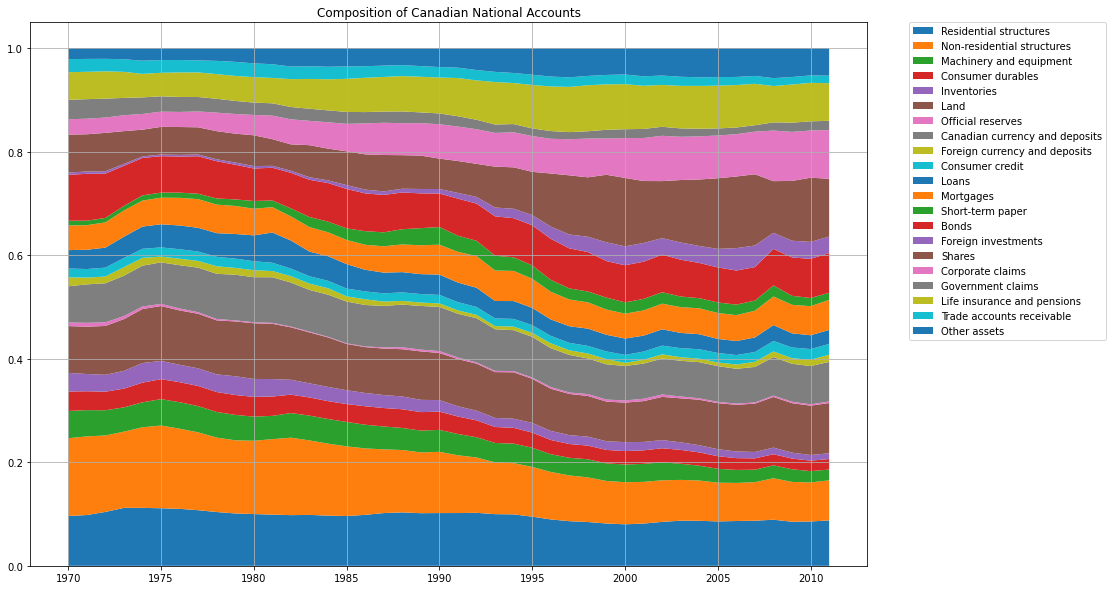

In [57]:
cats = [('Residential structures', None), ('Non-residential structures', None),('Machinery and equipment', None),
       ('Consumer durables', None), ('Inventories', None), ('Land', None), ('Official reserves', None),
       ('Canadian currency and deposits', '1.2.12'), ('Foreign currency and deposits', '1.2.13'),
       ('Consumer credit', '1.2.14'), ('Loans', '1.2.15'), ('Mortgages', '1.2.16'), ('Short-term paper', '1.2.17'),
       ('Bonds', '1.2.18'), ('Foreign investments', '1.2.20'), ('Shares', '1.2.21'), ('Corporate claims', '1.2.22'),
       ('Government claims', '1.2.23'), ('Life insurance and pensions', '1.2.24'), ('Trade accounts receivable', None),
       ('Other assets', None)]
plt.subplots(figsize=(15, 10));
values = []
labels = []
for cat in cats:
    if cat[1] == None:
        bool_statement = (temp['Categories'] == cat[0])
    else:
        bool_statement = (temp['Categories'] == cat[0]) & (temp['COORDINATE'] == cat[1])
    values.append(temp[bool_statement]['VALUE'].values/temp[temp['Categories'] == 'Total assets']['VALUE'].values)
    labels.append(cat[0])
  
plt.stackplot(temp[bool_statement]['REF_DATE'], values)
plt.legend(labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.yscale('log')
plt.grid('minor')
plt.title('Composition of Canadian National Accounts')
plt.show()

In [ ]:
#TODO industry contributions to GDP

The definition of the CPI and the obvious rise in real estate prices compared to incomes of the working class raises the obvious question.  What is the dollar worth?

The "value" of the dollar, or the purchasing power, is relative. Instead, here are some examples more informative metrics : 

* M0, M1, M2, or M3 money supply normalized by the Canadaian population
* Annual wages normalized by the CPI.
* Wages normalized by house price, as measured by sale price of the home.  

By thinking in terms of the total dollar value of different goods and asset classes normalized by the population, you can then think in terms of where you are relative to the average. If wages really have stagnated, then it should be obvious from this metric that the average person's purchasing power has reduced slowly over time.

In [5]:
#url = 'https://www.bankofcanada.ca/valet/observations/group/CPI_MONTHLY/json'
def get_boc_data(url):
    response = requests.get(url)
    d = json.loads(response.text)
    df = pd.json_normalize(d['observations'])
    df['d'] = pd.to_datetime(df['d'])
    df = df.set_index('d')
    return df, d['seriesDetail']

In [6]:
money_supply = get_boc_data('https://www.bankofcanada.ca/valet/observations/group/e1_monthly/json?start_date=1946-01-01')

The BOC has an overview of money aggregates on their website https://www.bankofcanada.ca/rates/banking-and-financial-statistics/selected-monetary-aggregates-and-their-components-formerly-e1/#graph.  Using this overview, I have selected a number of different measures which I want to normalize.

Now, just to see all the data I will iterate through the series and plot them.

In [7]:
# comment out data series you don't want in charts
json_data_keys = [#'V37173', 
                  #'V41552775_E1', 
                  #'V36818', 
                  #'V36823', 
                  #'V41552777_E1', 
                  #'V36828_E1', 
                  #'V41552789', 
                  'V41552786', 
                  #'V36830_E1', 
                  #'V36876_E1', 
                  #'V37250', 
                  'V41552785', 
                  'V41552786_E1', 
                  #'V122611003', 
                  #'V37245', 
                  #'V37251', 
                  'V41552788', 
                  #'V37255', 
                  #'V37256', 
                  #'V41552790', 
                  'V37258', 
                  'V37259']

In [8]:
def gen_clean_money(money_supply):
    def get_money(money_aggregate): # Remove data with nan values        
        df = pd.to_numeric(money_supply[0][money_aggregate+'.v'][money_supply[0][money_aggregate+'.v'].notna()])
        df.name = money_supply[1][money_aggregate]['label']
        return df
    return get_money
get_money = gen_clean_money(money_supply)

Below, we have an illustration of the aggregate money supply history.

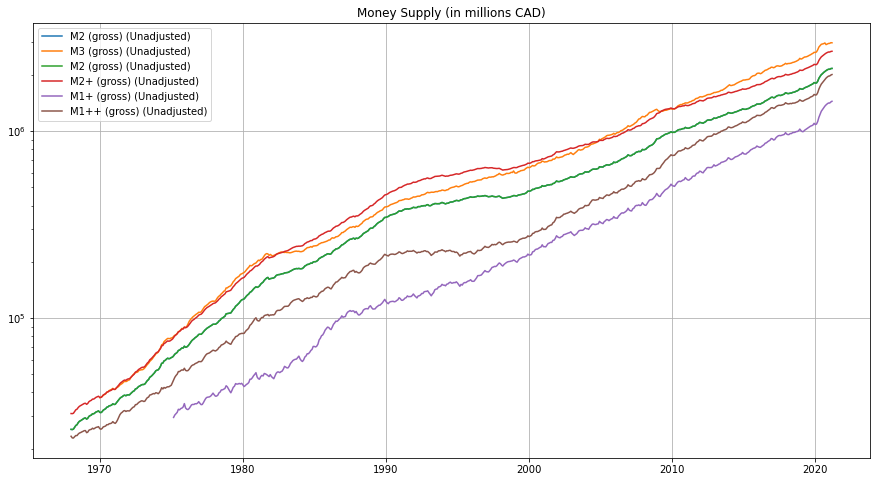

In [9]:
fig, ax = plt.subplots(figsize=(15, 8))
for item in json_data_keys:  
    df = get_money(item)
    ax.plot(df.index, df.values, label=df.name)

plt.title("Money Supply (in millions CAD)")    
plt.yscale('log')
plt.legend(loc="upper left")
plt.grid('minor')
plt.show()

In [10]:
sc = StatsCan(data_folder=os.getcwd() + '/stats_can_data')

In [11]:
pop_df = sc.table_to_df("17-10-0005-01")

17100005-eng.zip: 100%|███████████████████████████████████████████████████████████| 3.44M/3.44M [00:01<00:00, 2.91MB/s]


In [12]:
df = pop_df[(pop_df['Sex'] == 'Both sexes')]
df = df[df['Age group'] == 'All ages']
df = df[df['GEO'] == 'Canada'][['REF_DATE', 'VALUE']]

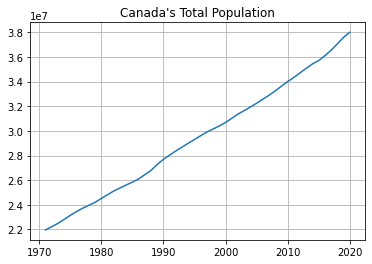

In [13]:
plt.plot(df['REF_DATE'], df['VALUE'])
plt.grid('minor')
plt.title("Canada's Total Population")
plt.show()

In [14]:
pop_norms = [(pd.to_datetime(item[1]['REF_DATE']).year, 1e6/item[1]['VALUE']) for item in df.iterrows()]

In [15]:
# interpolate the months between the annual population estimates in order to get smoother estimation of the normalized
# aggregate money supply
def gen_norm_func(norms):
    def norm_func(data_pair):
        norm = pipe(norms, 
                    partial(filter, lambda x: x[0] == data_pair[0]), 
                    list)
        if norm:
            data_value = data_pair[1]*norm[0][1]
            return (data_pair[0], data_value)
        else:
            return (data_pair[0], None)
    return norm_func

In [16]:
norm_func = gen_norm_func(pop_norms)
def money_supply_per_capita(money_aggregate):
    money = get_money(item)
    year_tuples = [(idx.year, value) for idx, value in money.items()]
    list_tuples = list(map(norm_func, year_tuples))    
    x = money.index
    y = [item[1] for item in list_tuples]
    return (x, y)

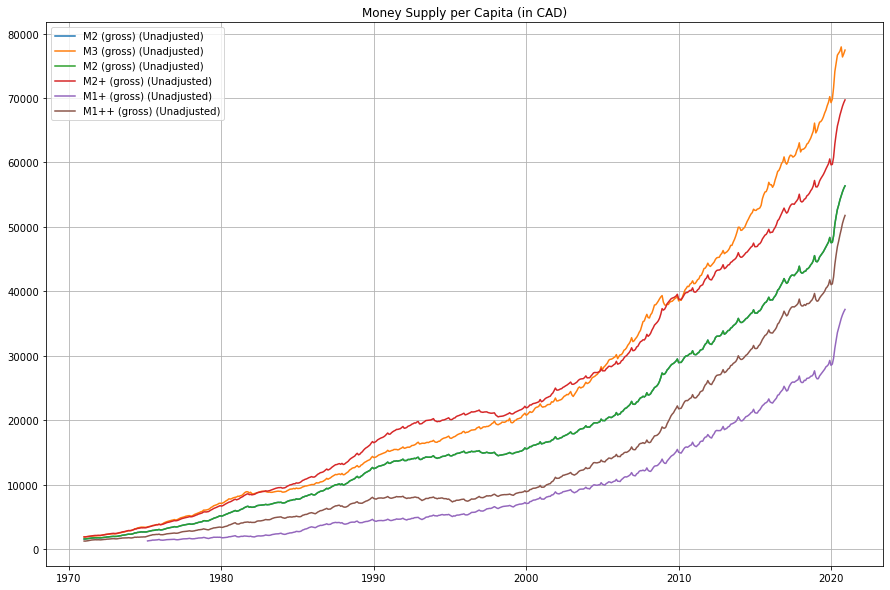

In [17]:
fig, ax = plt.subplots(figsize=(15, 10))
for item in json_data_keys:  
    money = get_money(item)
    year_tuples = [(idx.year, value) for idx, value in money.items()]
    list_tuples = list(map(norm_func, year_tuples))    
    x = money.index
    y = [item[1] for item in list_tuples]
    ax.plot(x, y, label=money.name)
    
plt.title("Money Supply per Capita (in CAD)")    
plt.legend(loc="upper left")
plt.grid('minor')
plt.show()

Load ontario wages.

In [18]:
df_ontario = pd.read_hdf(os.getcwd() + '/data/smaller_data_selection.h5')
df_ontario['REF_DATE'] = pd.to_datetime(df_ontario['REF_DATE'])

In [19]:
money_aggregate = json_data_keys[1]
money = get_money(money_aggregate)
year_tuples = [(idx.year, value) for idx, value in money.items()]
list_tuples = list(map(norm_func, year_tuples))    
x = money.index
y = [item[1] for item in list_tuples]
money_per_capita = (x, y)
per_capita_norms = [(item[0], 52/item[1]) for item in list(zip(*money_per_capita)) if item[1]]
norm_func = gen_norm_func(per_capita_norms)

In [20]:
occupations = ['Senior management occupations [00]',
       'Specialized middle management occupations [01-05]',
       'Middle management occupations in retail and wholesale trade and customer services [06]',
       'Middle management occupations in trades, transportation, production and utilities [07-09]',
       'Professional occupations in business and finance [11]',
       #'Administrative and financial supervisors and administrative occupations [12]',
       #'Finance, insurance and related business administrative occupations [13]',
       #'Office support occupations [14]',
       #'Distribution, tracking and scheduling co-ordination occupations [15]',
       'Professional occupations in natural and applied sciences [21]',
       #'Technical occupations related to natural and applied sciences [22]',
       'Professional occupations in nursing [30]',
       #'Professional occupations in health (except nursing) [31]',
       #'Technical occupations in health [32]',
       #'Assisting occupations in support of health services [34]',
       #'Professional occupations in education services [40]',
       #'Professional occupations in law and social, community and government services [41]',
       #'Paraprofessional occupations in legal, social, community and education services [42]',
       #'Occupations in front-line public protection services [43]',
       'Care providers and educational, legal and public protection support occupations [44]',
       #'Professional occupations in art and culture [51]',
       #'Technical occupations in art, culture, recreation and sport [52]',
       #'Retail sales supervisors and specialized sales occupations [62]',
       #'Service supervisors and specialized service occupations [63]',
       #'Sales representatives and salespersons - wholesale and retail trade [64]',
       #'Service representatives and other customer and personal services occupations [65]',
       'Sales support occupations [66]',
       #'Service support and other service occupations, n.e.c. [67]',
       'Industrial, electrical and construction trades [72]',
       'Maintenance and equipment operation trades [73]',
       #'Other installers, repairers and servicers and material handlers [74]',
       #'Transport and heavy equipment operation and related maintenance occupations [75]',
       'Trades helpers, construction labourers and related occupations [76]',
       #'Supervisors and technical occupations in natural resources, agriculture and related production [82]',
       #'Workers in natural resources, agriculture and related production [84]',
       #'Harvesting, landscaping and natural resources labourers [86]',
       #'Processing, manufacturing and utilities supervisors and central control operators [92]',
       #'Processing and manufacturing machine operators and related production workers [94]',
       'Assemblers in manufacturing [95]',
       #'Labourers in processing, manufacturing and utilities [96]'
        ]

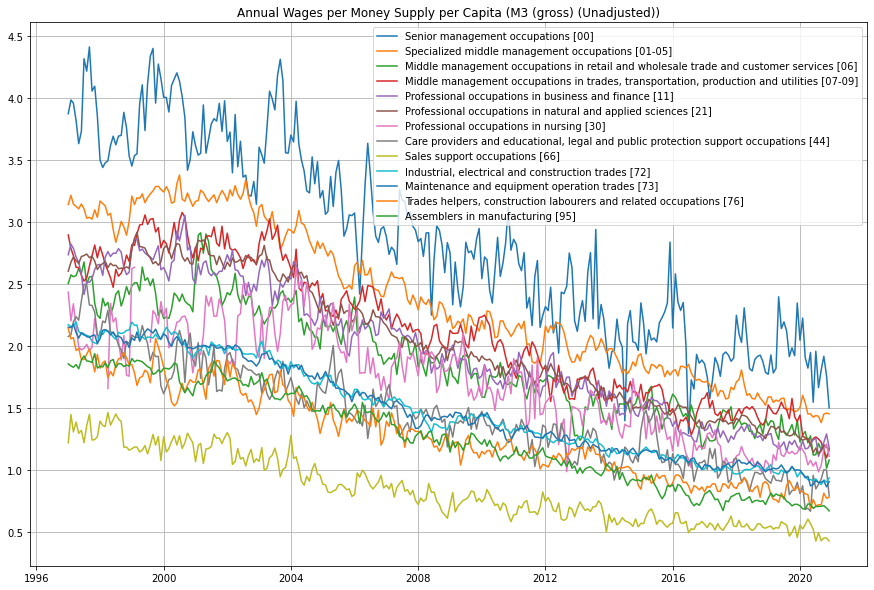

In [21]:
fig, ax = plt.subplots(figsize=(15, 10))
#for occupation in df_ontario['National Occupational Classification (NOC)'].unique():
for occupation in occupations:
    df_test = df_ontario[(df_ontario['UOM']=='Current dollars') &
                        (df_ontario['Age group'] == '25 to 54 years') &
                        (df_ontario['Wages'] == 'Average weekly wage rate') &
                        (df_ontario['Sex'] == 'Males') &
                        (df_ontario['National Occupational Classification (NOC)'] == occupation)]
    wages = [(item[1]['REF_DATE'], item[1]['VALUE']) for item in df_test.iterrows()]
    list_tuples = list(map(norm_func, wages))    
    normed_wages = list(zip(*list_tuples))
    ax.plot(normed_wages[0], normed_wages[1], label=occupation)
plt.title("Annual Wages per Money Supply per Capita (" + money.name + ")")    
plt.legend(loc="upper right")
plt.grid('minor')
plt.show()

# Compare to House Prices
To understand the change in wage earner's capacity to purchase a home, two sources for "home price index" are choosen. Depending on the source, two results emerge. 

1) When using the statistics canada housing price index, the wage to house price remains flat
2) When using the data from https://housepriceindex.ca, the house price to money supply remains constant and the wage over house price declines with time.

In other words, they way the government defines "house price" is done in a way so as to allow homes to appear "affordable".  But in reality, the price of homes is going beyond the reach of wage earner's capacity to own these homes.

In [22]:
house_index = pd.read_csv(os.getcwd() + '/data/House_Price_Index.csv', skiprows=[1])
house_index['Transaction Date'] = pd.to_datetime(house_index['Transaction Date'])
house_index = house_index[house_index['on_toronto'].notna()]

In [23]:
df = house_index

In [24]:
home_price = [(item[1]['Transaction Date'], item[1]['on_toronto']) for item in df.iterrows() if not math.isnan(item[1]['on_toronto'])]

In [25]:
norm_func = gen_norm_func(per_capita_norms)
list_tuples = list(map(norm_func, home_price))    
home_price_per_money_supply_per_capita = list(zip(*list_tuples))

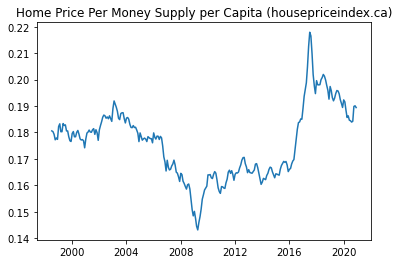

In [26]:
plt.plot(home_price_per_money_supply_per_capita[0], home_price_per_money_supply_per_capita[1])
plt.title("Home Price Per Money Supply per Capita (housepriceindex.ca)")
plt.show()

In [27]:
home_price = [(item[1]['Transaction Date'], 52/item[1]['on_toronto']) for item in df.iterrows() if not math.isnan(item[1]['on_toronto'])]
norm_func = gen_norm_func(home_price)
occupation = occupations[0]
df_test = df_ontario[(df_ontario['UOM']=='Current dollars') &
                    (df_ontario['Age group'] == '25 to 54 years') &
                    (df_ontario['Wages'] == 'Average weekly wage rate') &
                    (df_ontario['Sex'] == 'Males') &
                    (df_ontario['National Occupational Classification (NOC)'] == occupation)]
wages = [(item[1]['REF_DATE'], item[1]['VALUE']) for item in df_test.iterrows()]
list_tuples = list(map(norm_func, wages))   
normed_wages = list(zip(*list_tuples))

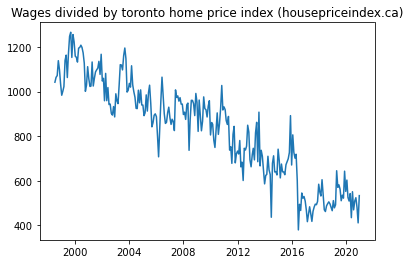

In [28]:
plt.plot(normed_wages[0], normed_wages[1], label=occupation)
plt.title('Wages divided by toronto home price index (housepriceindex.ca)')
plt.show()

In [29]:
house_index = sc.table_to_df('18-10-0205-01')

18100205-eng.zip: 100%|█████████████████████████████████████████████████████████████| 309k/309k [00:00<00:00, 2.79MB/s]


In [30]:
house_index = house_index[(house_index['GEO']=='Toronto, Ontario') &
                        (house_index['New housing price indexes'] == 'Total (house and land)')]

In [31]:
home_price = [(item[1]['REF_DATE'], item[1]['VALUE']) for item in house_index.iterrows()]

In [32]:
norm_func = gen_norm_func(per_capita_norms)
list_tuples = list(map(norm_func, home_price))    
home_price_per_money_supply_per_capita = list(zip(*list_tuples))

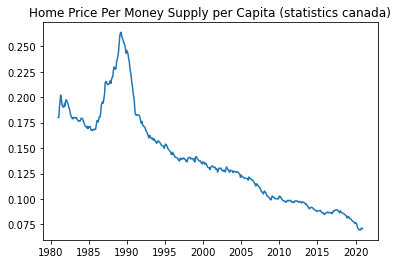

In [33]:
plt.plot(home_price_per_money_supply_per_capita[0], home_price_per_money_supply_per_capita[1])
plt.title("Home Price Per Money Supply per Capita (statistics canada)")
plt.show()

In [34]:
#home_price = [(item[1]['Transaction Date'], 52/item[1]['on_toronto']) for item in df.iterrows() if not math.isnan(item[1]['on_toronto'])]
home_price = [(item[1]['REF_DATE'], 52/item[1]['VALUE']) for item in house_index.iterrows()]
norm_func = gen_norm_func(home_price)
occupation = occupations[0]
df_test = df_ontario[(df_ontario['UOM']=='Current dollars') &
                    (df_ontario['Age group'] == '25 to 54 years') &
                    (df_ontario['Wages'] == 'Average weekly wage rate') &
                    (df_ontario['Sex'] == 'Males') &
                    (df_ontario['National Occupational Classification (NOC)'] == occupation)]
wages = [(item[1]['REF_DATE'], item[1]['VALUE']) for item in df_test.iterrows()]
list_tuples = list(map(norm_func, wages))   
normed_wages = list(zip(*list_tuples))

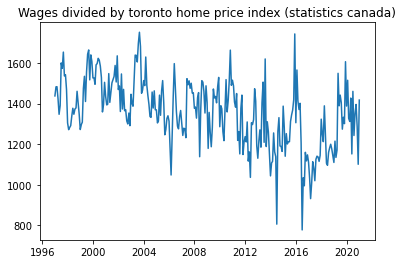

In [35]:
plt.plot(normed_wages[0], normed_wages[1], label=occupation)
plt.title('Wages divided by toronto home price index (statistics canada)')
plt.show()

# Housing Supply
The idea here, is to illustrate the housing supply per person.  The concept, is that if housing price increases are caused by too few houses per capita, there should be reflected in the data.  Observing below, there does seem to be a decline in housing supply per capita.

In [36]:
house_supply = sc.table_to_df('34-10-0135-01')
quarter_pop = sc.table_to_df('17-10-0009-01 ')

34100135-eng.zip: 100%|█████████████████████████████████████████████████████████████| 564k/564k [00:00<00:00, 2.80MB/s]


17100009-eng.zip: 100%|███████████████████████████████████████████████████████████| 27.9k/27.9k [00:00<00:00, 1.57MB/s]


In [37]:
df = quarter_pop[(quarter_pop['GEO']=='Canada')]      
df2 = df.copy()
df2['VALUE'] = df['VALUE'] - df['VALUE'].shift(1)

In [38]:
norm_pop = [(item[1]['REF_DATE'], 1/item[1]['VALUE']) for item in df2.iterrows() if not math.isnan(item[1]['VALUE'])]

In [39]:
house_supply['GEO'].unique()
df = house_supply[(house_supply['GEO']=='Canada') &
                 (house_supply['Housing estimates'] == 'Housing completions') &
                 (house_supply['Type of unit'] == 'Total units')]

In [40]:
home_supply = [(item[1]['REF_DATE'], item[1]['VALUE']) for item in df.iterrows() if not math.isnan(item[1]['VALUE'])]

In [41]:
norm_func = gen_norm_func(norm_pop)
list_tuples = list(map(norm_func, home_supply))    
home_supply_per_pop_increase = list(zip(*list_tuples))

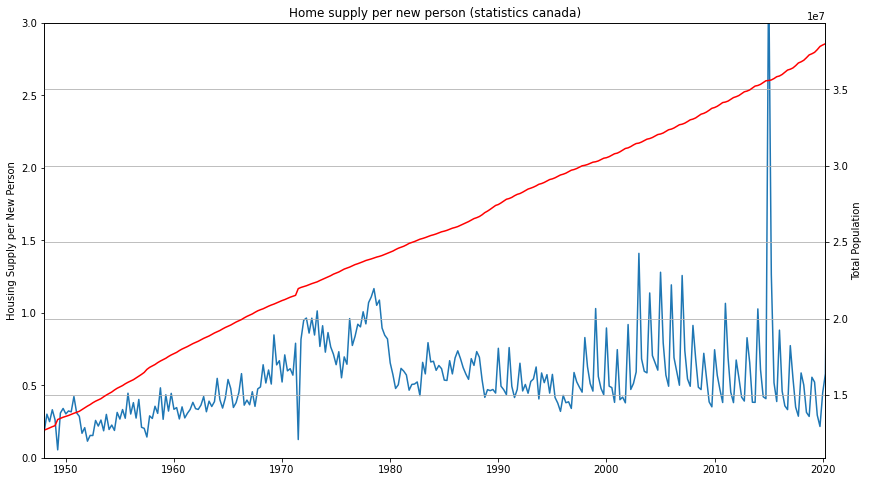

In [42]:
fig, ax1 = plt.subplots(figsize=(14, 8))
ax2 = ax1.twinx()

ax1.plot(home_supply_per_pop_increase[0], home_supply_per_pop_increase[1], label='Housing per new person')
ax1.set_ylim([0, 3])
ax1.set_ylabel('Housing Supply per New Person')
ax2.plot(quarter_pop[quarter_pop['GEO'] == 'Canada']['REF_DATE'].values, 
         quarter_pop[quarter_pop['GEO'] == 'Canada']['VALUE'].values, color='r', label='Total Population')
ax2.set_ylabel('Total Population')
plt.title("Home supply per new person (statistics canada)")

plt.xlim([pd.Timestamp('1948-01-01 00:00:00'), pd.Timestamp('2020-04-01 00:00:00')])


plt.grid('minor')
plt.show()

# CPI to Money Supply per Capita Constant
To clarify the effective relation between the CPI and wages, we normalize wages to the CPI, as defined by Statistics Canada.  

In [43]:
cpi = get_boc_data('https://www.bankofcanada.ca/valet/observations/group/CPI_MONTHLY/json')

In [44]:
cpi_df = sc.table_to_df('18-10-0004-01')

18100004-eng.zip: 100%|███████████████████████████████████████████████████████████| 13.5M/13.5M [00:04<00:00, 3.10MB/s]


In [45]:
cpi_df = cpi_df[cpi_df['GEO'].isin(['Toronto, Ontario'])]
cpi_df = cpi_df[cpi_df['Products and product groups'].isin(['All-items'])]
cpi_df['REF_DATE'] = pd.to_datetime(cpi_df['REF_DATE'])

Illustration of the CPI over time. 

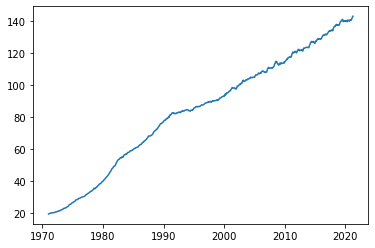

In [46]:
plt.plot(cpi_df['REF_DATE'], cpi_df['VALUE'])
plt.show()

In [47]:
cpi_index = cpi_df['VALUE'].values
dates = []
for date in cpi_df['REF_DATE'].values:
    dates.append(pd.to_datetime(date))

In [48]:
norm_pop = [(item[1]['REF_DATE'], 1/item[1]['VALUE']) for item in df.iterrows() if not math.isnan(item[1]['VALUE'])]

In [49]:
occupations = ['Senior management occupations [00]',
       'Specialized middle management occupations [01-05]',
       'Middle management occupations in retail and wholesale trade and customer services [06]',
       'Middle management occupations in trades, transportation, production and utilities [07-09]',
       'Professional occupations in business and finance [11]',
       #'Administrative and financial supervisors and administrative occupations [12]',
       #'Finance, insurance and related business administrative occupations [13]',
       #'Office support occupations [14]',
       #'Distribution, tracking and scheduling co-ordination occupations [15]',
       'Professional occupations in natural and applied sciences [21]',
       #'Technical occupations related to natural and applied sciences [22]',
       'Professional occupations in nursing [30]',
       #'Professional occupations in health (except nursing) [31]',
       #'Technical occupations in health [32]',
       #'Assisting occupations in support of health services [34]',
       #'Professional occupations in education services [40]',
       #'Professional occupations in law and social, community and government services [41]',
       #'Paraprofessional occupations in legal, social, community and education services [42]',
       #'Occupations in front-line public protection services [43]',
       'Care providers and educational, legal and public protection support occupations [44]',
       #'Professional occupations in art and culture [51]',
       #'Technical occupations in art, culture, recreation and sport [52]',
       #'Retail sales supervisors and specialized sales occupations [62]',
       #'Service supervisors and specialized service occupations [63]',
       #'Sales representatives and salespersons - wholesale and retail trade [64]',
       #'Service representatives and other customer and personal services occupations [65]',
       'Sales support occupations [66]',
       #'Service support and other service occupations, n.e.c. [67]',
       'Industrial, electrical and construction trades [72]',
       'Maintenance and equipment operation trades [73]',
       #'Other installers, repairers and servicers and material handlers [74]',
       #'Transport and heavy equipment operation and related maintenance occupations [75]',
       'Trades helpers, construction labourers and related occupations [76]',
       #'Supervisors and technical occupations in natural resources, agriculture and related production [82]',
       #'Workers in natural resources, agriculture and related production [84]',
       #'Harvesting, landscaping and natural resources labourers [86]',
       #'Processing, manufacturing and utilities supervisors and central control operators [92]',
       #'Processing and manufacturing machine operators and related production workers [94]',
       'Assemblers in manufacturing [95]',
       #'Labourers in processing, manufacturing and utilities [96]'
        ]

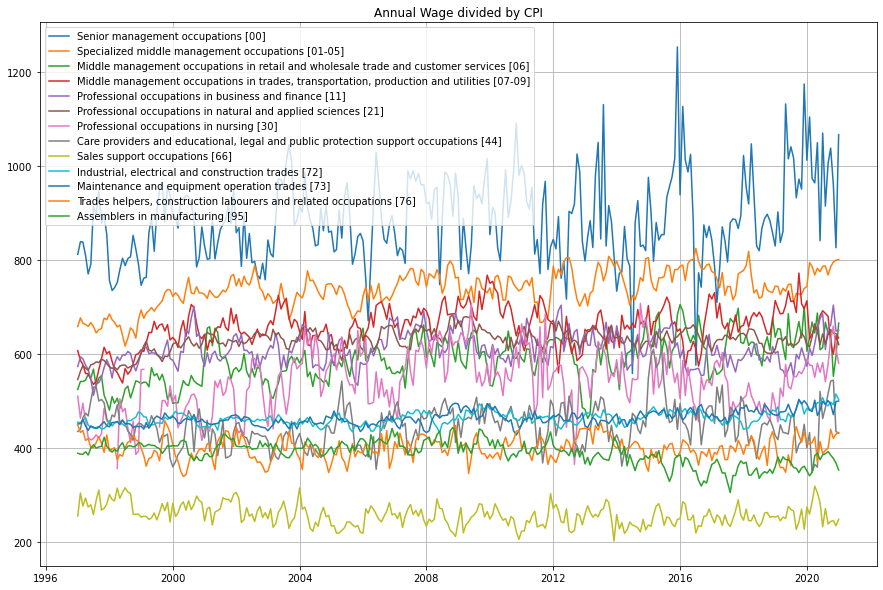

In [50]:
plt.subplots(figsize=(15, 10))
legend_labels = []
for category in occupations:#df_ontario['National Occupational Classification (NOC)'].unique():
    df_test = df_ontario[(df_ontario['UOM']=='Current dollars') &
                            (df_ontario['Age group'] == '25 to 54 years') &
                            (df_ontario['Wages'] == 'Average weekly wage rate') &
                            (df_ontario['Sex'] == 'Males') &
                            (df_ontario['National Occupational Classification (NOC)'] == category)]
    #df_test = df_test[df_test['CATEGORY'].isin(['Management occupations [0]', 'Natural and applied sciences and related occupations [2]'])]

    normed_wages = []
    x_dates = []
    cpi = []
    annual_wage = []
    for wage_data in df_test.iterrows():
        date_data = pd.to_datetime(wage_data[1]['REF_DATE'])
        wage_point = wage_data[1]['VALUE']
        try:
            norm = cpi_index[dates.index(date_data)]
            normed_wages.append(52*wage_point/norm)
            annual_wage.append(wage_point*52)
            cpi.append(norm)
            x_dates.append(date_data)
        except:
            print("OH WELL")
        #print(item)
    if df_test.shape[0] > 0:
        plt.plot(x_dates, normed_wages, label=category)
plt.legend()
plt.title("Annual Wage divided by CPI")
plt.grid('minor')
plt.show()